In [60]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saifk\AppData\Local\Temp\ipykernel_23376\1460225398.py:3: SyntaxWarning: invalid escape sequence '\T'
  train_dir = "Teeth DataSet\Teeth_Dataset\Training"


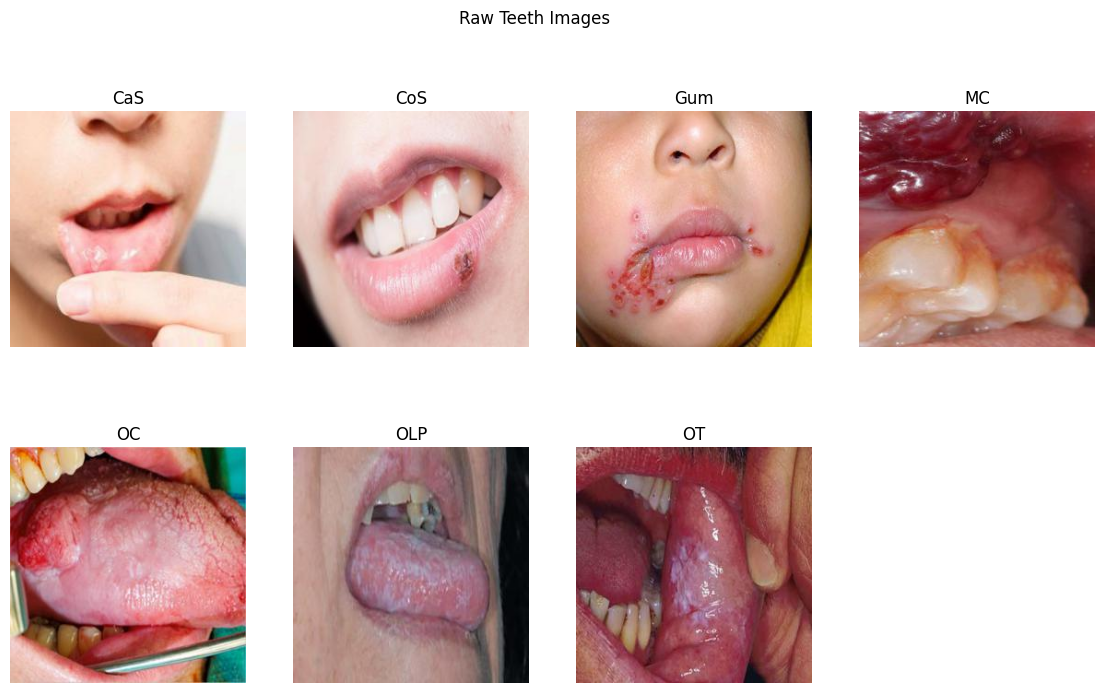

In [61]:
from PIL import Image

train_dir = "Teeth DataSet\Teeth_Dataset\Training"
classes = os.listdir(train_dir)

plt.figure(figsize=(14, 8))

for i, cls in enumerate(classes):
    img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = Image.open(img_path)

    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Raw Teeth Images")
plt.show()


In [62]:
import pandas as pd

def class_distribution(path):
    return {cls: len(os.listdir(os.path.join(path, cls)))
            for cls in os.listdir(path)}

train_dist = class_distribution("Teeth DataSet\Teeth_Dataset\Training")
val_dist   = class_distribution("Teeth DataSet\Teeth_Dataset\Validation")
test_dist  = class_distribution("Teeth DataSet\Teeth_Dataset\Testing - Copy")

df = pd.DataFrame({
    "Train": train_dist,
    "Validation": val_dist,
    "Test": test_dist
})



<>:7: SyntaxWarning: invalid escape sequence '\T'
<>:8: SyntaxWarning: invalid escape sequence '\T'
<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:7: SyntaxWarning: invalid escape sequence '\T'
<>:8: SyntaxWarning: invalid escape sequence '\T'
<>:9: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saifk\AppData\Local\Temp\ipykernel_23376\857661665.py:7: SyntaxWarning: invalid escape sequence '\T'
  train_dist = class_distribution("Teeth DataSet\Teeth_Dataset\Training")
C:\Users\saifk\AppData\Local\Temp\ipykernel_23376\857661665.py:8: SyntaxWarning: invalid escape sequence '\T'
  val_dist   = class_distribution("Teeth DataSet\Teeth_Dataset\Validation")
C:\Users\saifk\AppData\Local\Temp\ipykernel_23376\857661665.py:9: SyntaxWarning: invalid escape sequence '\T'
  test_dist  = class_distribution("Teeth DataSet\Teeth_Dataset\Testing - Copy")


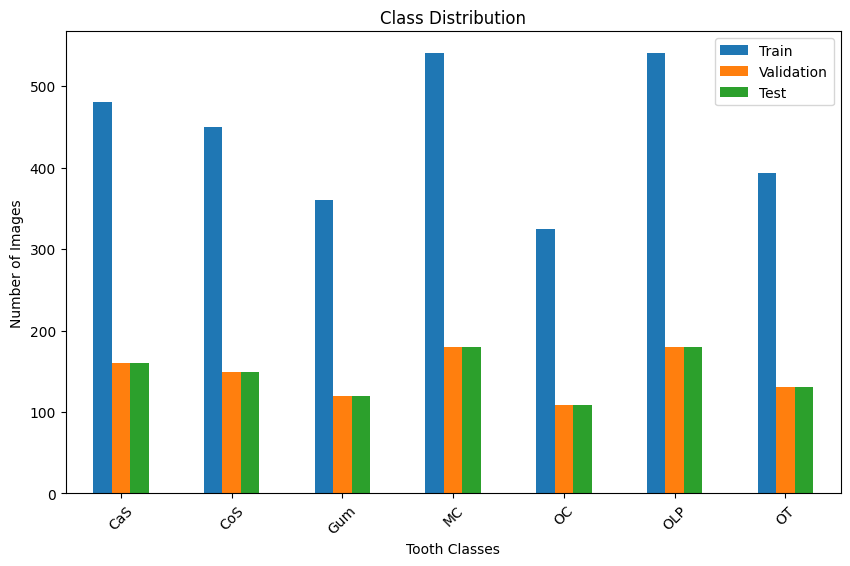

In [63]:
df.plot(kind="bar", figsize=(10,6))
plt.title("Class Distribution")
plt.xlabel("Tooth Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [64]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # input formatting
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),                    # converts to [0,1]
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


In [65]:
train_dataset = datasets.ImageFolder("Teeth DataSet\Teeth_Dataset\Training", transform=train_transform)
val_dataset   = datasets.ImageFolder("Teeth DataSet\Teeth_Dataset\Validation", transform=val_test_transform)
test_dataset  = datasets.ImageFolder("Teeth DataSet\Teeth_Dataset\Testing - Copy", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
NUM_CLASSES = len(class_names)


<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saifk\AppData\Local\Temp\ipykernel_23376\3920812833.py:1: SyntaxWarning: invalid escape sequence '\T'
  train_dataset = datasets.ImageFolder("Teeth DataSet\Teeth_Dataset\Training", transform=train_transform)
C:\Users\saifk\AppData\Local\Temp\ipykernel_23376\3920812833.py:2: SyntaxWarning: invalid escape sequence '\T'
  val_dataset   = datasets.ImageFolder("Teeth DataSet\Teeth_Dataset\Validation", transform=val_test_transform)
C:\Users\saifk\AppData\Local\Temp\ipykernel_23376\3920812833.py:3: SyntaxWarning: invalid escape sequence '\T'
  test_dataset  = datasets.ImageFolder("Teeth DataSet\Teeth_Dataset\Testing - Copy", transform=val_test_transform)


In [66]:
class TeethCNN(nn.Module):
    def __init__(self, num_classes):
        super(TeethCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [67]:
model = TeethCNN(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [68]:
from tqdm import tqdm

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", leave=False)

    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix({
            "loss": f"{running_loss / (total / labels.size(0)):.4f}",
            "acc": f"{correct / total:.4f}"
        })

    train_acc = correct / total

    # 🔹 Validation phase (no progress bar needed, but we can add one)
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")



Epoch [1/20] Train Acc: 0.1957 | Val Acc: 0.2870


Epoch [2/20] Train Acc: 0.2854 | Val Acc: 0.3327


Epoch [3/20] Train Acc: 0.3158 | Val Acc: 0.3589


Epoch [4/20] Train Acc: 0.3434 | Val Acc: 0.3765


Epoch [5/20] Train Acc: 0.3479 | Val Acc: 0.4193


Epoch [6/20] Train Acc: 0.3599 | Val Acc: 0.4232


Epoch [7/20] Train Acc: 0.3991 | Val Acc: 0.4660


Epoch [8/20] Train Acc: 0.3978 | Val Acc: 0.4475


Epoch [9/20] Train Acc: 0.4218 | Val Acc: 0.5107


Epoch [10/20] Train Acc: 0.4406 | Val Acc: 0.5185


Epoch [11/20] Train Acc: 0.4464 | Val Acc: 0.5204


Epoch [12/20] Train Acc: 0.4577 | Val Acc: 0.5554


Epoch [13/20] Train Acc: 0.4704 | Val Acc: 0.5525


Epoch [14/20] Train Acc: 0.4846 | Val Acc: 0.5632


Epoch [15/20] Train Acc: 0.4817 | Val Acc: 0.5574


Epoch [16/20] Train Acc: 0.5079 | Val Acc: 0.5866


Epoch [17/20] Train Acc: 0.5096 | Val Acc: 0.5749


Epoch [18/20] Train Acc: 0.5134 | Val Acc: 0.5963


Epoch [19/20] Train Acc: 0.5287 | Val Acc: 0.5837


Epoch [20/20] Train Acc: 0.5287 | Val Acc: 0.6177


In [69]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Test Accuracy:", correct / total)


Test Accuracy: 0.6196498054474708


In [70]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

         CaS       0.61      0.66      0.63       160
         CoS       0.75      0.74      0.75       149
         Gum       0.73      0.62      0.67       120
          MC       0.51      0.62      0.56       180
          OC       0.61      0.43      0.50       108
         OLP       0.56      0.69      0.62       180
          OT       0.72      0.49      0.58       131

    accuracy                           0.62      1028
   macro avg       0.64      0.61      0.62      1028
weighted avg       0.63      0.62      0.62      1028



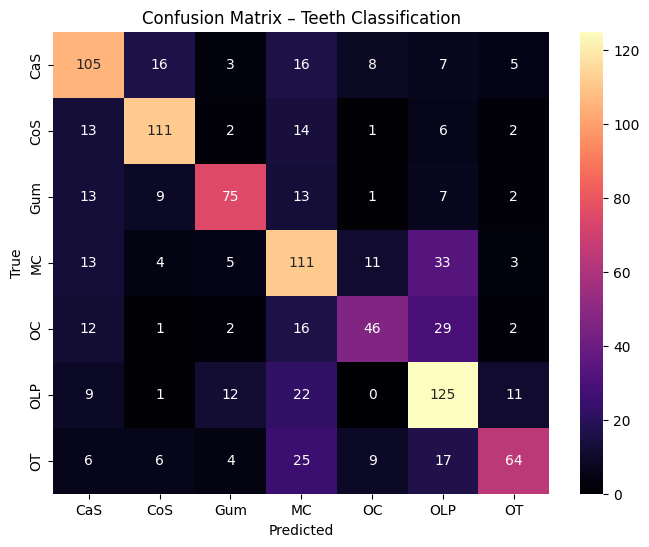

In [72]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="magma")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Teeth Classification")
plt.show()
